In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../GlacierLakeDetectionICESat2/GlacierLakeIS2ML/')

from IS2ML_utils import *

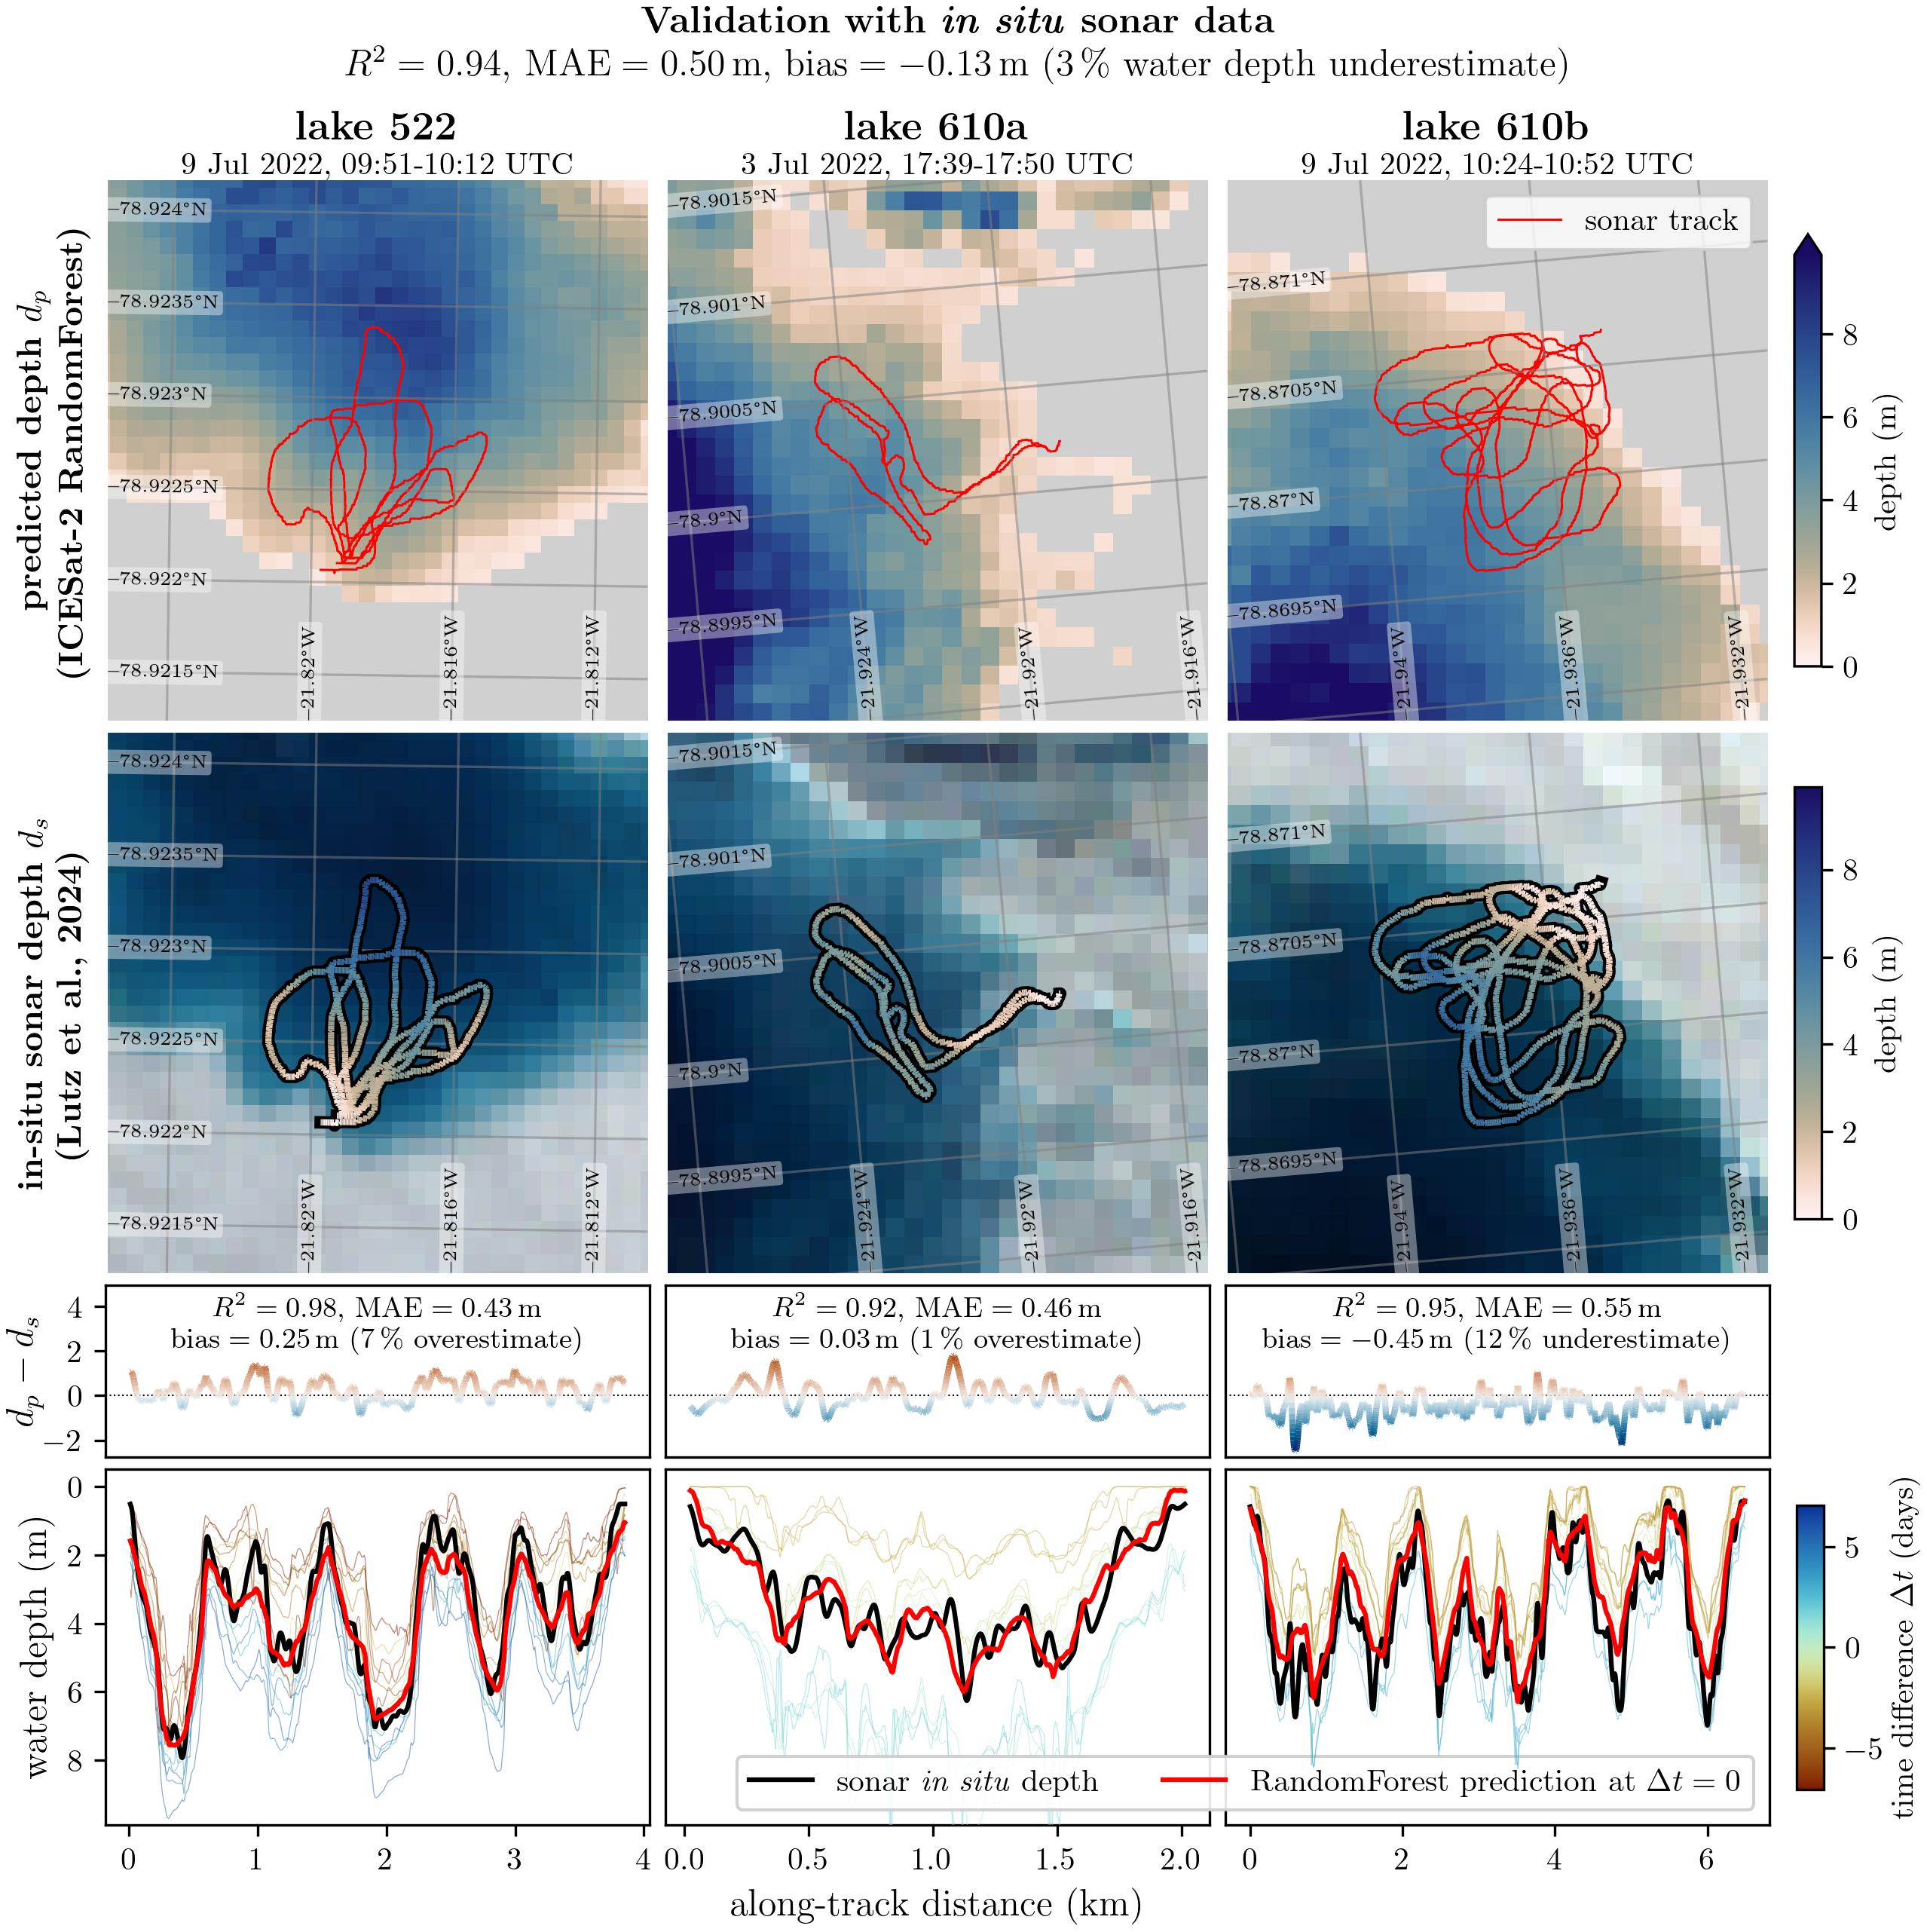

In [2]:
ids = ['Sonar_2022-07-09_lake522',
       'Sonar_2022-07-04_lake610a',
       'Sonar_2022-07-09_lake610b']

plt.rcParams.update({
    'font.size': 10,
    "text.usetex": True,
    "font.family": "Optima"
})

df_ensembl = pd.read_csv('data/sonar/along_track_validation_ensemble_mean_7d_predictions.csv')
df_result_valid = pd.read_csv('data/sonar/along_track_validation_individual_estimates.csv')

plt.close('all')

fig = plt.figure(figsize=[8.5,8.7], dpi=80)
gs = fig.add_gridspec(ncols=3, nrows=9)
axs = []
for i in range(2):
    for j in range(3):
        axs.append(fig.add_subplot(gs[i*3:(i+1)*3, j]))
for i in range(3):
    axs.append(fig.add_subplot(gs[6, i]))
for i in range(3):
    axs.append(fig.add_subplot(gs[7:, i]))

vmin = 0
vmax = 9.9
cmap = cmc.lapaz_r
lw_col = 2

fs_side = matplotlib.rcParams['font.size']+1
fs_top = matplotlib.rcParams['font.size']+3

# graticule params
b_rems = [(2, 0), (2, 0), (2, 0)]
tbbx_grat = dict(facecolor='white', alpha=0.4, edgecolor='none', boxstyle="Round, pad=0.2")
grat_me_locs = ['bottom']
grat_pa_locs = ['left']
grat_mlines = 6
grat_fs = 6
grat_txtcol = 'black'
grat_gridcol = 'gray'
grat_gridls = '-'
grat_gridlw = 0.8
cbar_wid = 0.05
labsz = matplotlib.rcParams['font.size']+2

for iid, id_sonar in enumerate(ids):
    
    img_fn_pred = 'data/sonar/validation_depth_estimates_' + id_sonar + '.tiff'
    # print(img_fn_pred)
    img_dat = rio.open(img_fn_pred)
    crs_img = img_dat.crs

    tformat_in = '%Y-%m-%d %H:%M:%SZ'
    tformat_start = '%-d %b %Y, %H:%M'
    tformat_end = '%H:%M'
    gdf = gpd.read_file('data/sonar/lutz_2024/%s.shp' % id_sonar)
    gdf['timestamp'] = gdf.apply(lambda x: datetime.timestamp(datetime.strptime(x.Time, tformat_in).replace(tzinfo=timezone.utc)), axis=1)
    date_time_start = datetime.strftime(datetime.fromtimestamp(gdf.timestamp.min(), tz=timezone.utc), tformat_start)
    date_time_end = datetime.strftime(datetime.fromtimestamp(gdf.timestamp.max(), tz=timezone.utc), tformat_end)
    date_time_print = '%s-%s UTC' % (date_time_start, date_time_end)
    
    dfs = df_ensembl[df_ensembl.id_lake == ('lutz_' + id_sonar)].copy()
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(crs_img)
    gdfs[['x_img', 'y_img']] = gdfs.geometry.get_coordinates()

    fac_lims = 1.1
    xr = gdfs.x_img.max() - gdfs.x_img.min()
    yr = gdfs.y_img.max() - gdfs.y_img.min()
    rng = np.max((xr, yr))
    xc = (gdfs.x_img.min() + gdfs.x_img.max()) / 2
    yc = (gdfs.y_img.min() + gdfs.y_img.max()) / 2
    xl_img = (xc - fac_lims*rng, xc + fac_lims*rng)
    yl_img = (yc - fac_lims*rng, yc + fac_lims*rng)

    ###########################################################
    # PREDICTED IMAGE
    ax = axs[iid]
    data = img_dat.read(1)
    
    extend = 'max' if np.percentile(data, 98) > vmax else 'neither'
    imgp = rioplot.show(data, ax=ax, transform=img_dat.transform, cmap=cmap, vmin=vmin, vmax=vmax)
    data_ = data
    data_[data_ < gdfs.depth.min()] = 0.0
    data_[data_ > 0] = np.nan
    rioplot.show(data_, ax=ax, transform=img_dat.transform, cmap=cmc.grayC, vmin=-1, vmax=5)
    if iid == 2:
        cax = ax.inset_axes([1.05, 0.1, cbar_wid, 0.8])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.nanmin(data), vmax=vmax))
        sm._A = []
        cbar = plt.colorbar(sm, cax=cax, orientation='vertical', extend=extend)
        cbar.set_label('depth (m)')
    track_p = ax.plot(gdfs.x_img, gdfs.y_img, 'r-', lw=0.7, label='sonar track')
    ax.axis('off')
    ax.set_xlim(xl_img)
    ax.set_ylim(yl_img)
    add_graticule_crs(ax, crs=crs_img, meridians_locs=grat_me_locs, parallels_locs=grat_pa_locs, max_lines=grat_mlines, fontsz=grat_fs, 
                      color=grat_txtcol, addleft=r'--', addright=r'--', gridcol=grat_gridcol, gridls=grat_gridls, gridlw=grat_gridlw, 
                      inside=True, b_rem_me=b_rems[iid], tbbx=tbbx_grat)
    tit = id_sonar.split('_')[-1].replace('lake', 'lake ')
    ax.text(0.5, 1.06, '\\textbf{%s}' % tit, fontsize=fs_top, ha='center', va='bottom', transform=ax.transAxes)
    ax.text(0.5, 1.0, date_time_print, ha='center', va='bottom', transform=ax.transAxes)
    if iid == 0:
        ax.text(-0.1, 0.5, '\\textbf{predicted depth $d_p$}\n\\textbf{(ICESat-2 RandomForest)}', rotation='vertical', transform=ax.transAxes, 
                ha='center', va='center', fontsize=fs_side)
    if iid == 2:
        ax.legend(loc='upper right')
        
    ###########################################################
    # SONAR DATA
    ax = axs[iid + 3]
    rgb = img_dat.read([4,3,2])
    rgb = rgb / np.max(rgb)
    rioplot.show(rgb, ax=ax, transform=img_dat.transform)
    plot_colorline(x=gdfs.x_img, y=gdfs.y_img, c=gdfs.depth_smooth, cmap=cmap, ax=ax, lw=lw_col, vmin=vmin, vmax=vmax, zorder=11)
    if iid == 2:
        cax = ax.inset_axes([1.05, 0.1, cbar_wid, 0.8])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.nanmin(data), vmax=vmax))
        sm._A = []
        cbar = plt.colorbar(sm, cax=cax, orientation='vertical', extend='neither')
        cbar.set_label('depth (m)')
    ax.plot(gdfs.x_img, gdfs.y_img, 'k-', lw=lw_col*2, zorder=10)
    ax.axis('off')
    ax.set_xlim(xl_img)
    ax.set_ylim(yl_img)
    add_graticule_crs(ax, crs=crs_img, meridians_locs=grat_me_locs, parallels_locs=grat_pa_locs, max_lines=grat_mlines, fontsz=grat_fs, 
                      color=grat_txtcol, addleft=r'--', addright=r'--', gridcol=grat_gridcol, gridls=grat_gridls, gridlw=grat_gridlw, 
                      inside=True, b_rem_me=b_rems[iid], tbbx=tbbx_grat)
    if iid == 0:
        ax.text(-0.1, 0.5, '\\textbf{in-situ sonar depth $d_s$}\n\\textbf{(Lutz et al., 2024)}', rotation='vertical', transform=ax.transAxes, 
                ha='center', va='center', fontsize=fs_side)

    ###########################################################
    # ALONG-TRACK Differences and stats
    ax = axs[iid + 6]
    err_range = 2.75
    ddiff = gdfs.depth_pred_mean - gdfs.depth_smooth
    cmap_err = cmc.vik
    plot_colorline(x=gdfs.xatc/1000, y=ddiff, c=ddiff, cmap=cmap_err, ax=ax, lw=lw_col, 
                   vmin=-err_range, vmax=err_range, zorder=11, autoscale=True)
    ax.axhline(0, color='k', lw=0.5, ls=':')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim(-err_range, err_range*1.8)
    ax.set_yticks([-2,0,2,4])
    if iid > 0: 
        ax.get_yaxis().set_visible(False)
    if iid == 0:
        ax.set_ylabel('$d_p - d_s$', labelpad=0.1, fontsize=labsz)

    mae_ = np.mean(np.abs(ddiff))
    bias_ = np.mean(ddiff)
    rsquare_ = pearsonr(gdfs.depth_pred_mean, gdfs.depth_smooth).statistic
    perc_ = np.sum(ddiff) / np.sum(gdfs.depth_smooth) * 100
    over_under_ = 'overestimate' if perc_ > 0 else 'underestimate'
    rsquare = pearsonr(df_ensembl.depth_pred_mean, df_ensembl.depth_smooth).statistic
    txt = '$R^2 = %.2f$, $\\mathrm{MAE}=%.2f\\mathrm{\\,m}$\n' % (rsquare_, mae_)
    txt += '$\\mathrm{bias} = %.2f\mathrm{\\,m}$ ($%.0f\\mathrm{\\,\\%%}$ %s)' % (bias_, np.abs(perc_), over_under_)
    ax.text(0.5, 0.78, txt, ha='center', va='center', transform=ax.transAxes, fontsize=9)

    ###########################################################
    # ALONG-TRACK COMPARISON
    ax = axs[iid + 9]
    p_sonar, = ax.plot(gdfs.xatc/1000, gdfs.depth_smooth, 'k-', label='sonar \\textit{in situ} depth', zorder=11)
    p_pred, = ax.plot(gdfs.xatc/1000, gdfs.depth_pred_mean, 'r-', label=r'RandomForest prediction at $\Delta t=0$', zorder=11)

    cmap_tdiff = cmc.roma
    vmx = np.nanmax(np.abs(df_result_valid.tdiff_sec))
    df_lake = df_result_valid[df_result_valid.id_lake == ('lutz_'+id_sonar)]
    for iimg, thisid in enumerate(df_lake.IS2_id.unique()):
        df_f = df_lake[df_lake.IS2_id == thisid]
        thiscol = cmap_tdiff((df_f.tdiff_sec.mean() + vmx) / (2*vmx))
        ax.plot(df_f.xatc/1000, df_f.depth_pred, color=thiscol, alpha=0.5, lw=0.3, zorder=10)
    
    ax.set_ylim((vmax-0.0001, -0.5))
    ax.set_yticks([0,2,4,6,8])
    if iid == 1:
        ax.set_xlabel('along-track distance (km)', fontsize=labsz)
    if iid == 0:
        ax.set_ylabel('water depth (m)', fontsize=labsz)
    else:
        ax.get_yaxis().set_visible(False)
    if iid == 2:
        cax = ax.inset_axes([1.05, 0.1, cbar_wid, 0.8])
        sm = plt.cm.ScalarMappable(cmap=cmap_tdiff, norm=plt.Normalize(vmin=-vmx/3600/24, vmax=vmx/3600/24))
        sm._A = []
        cbar = plt.colorbar(sm, cax=cax, orientation='vertical', extend='neither')
        cbar.set_label(r'time difference $\Delta t$ (days)', labelpad=1)

ddiff = df_ensembl.depth_pred_mean - df_ensembl.depth_smooth
mae = np.mean(np.abs(ddiff))
bias = np.mean(ddiff)
perc = np.sum(ddiff) / np.sum(df_ensembl.depth_smooth) * 100
rsquare = pearsonr(df_ensembl.depth_pred_mean, df_ensembl.depth_smooth).statistic
over_under = 'overestimate' if perc > 0 else 'underestimate'
txt = '\\textbf{Validation with \\textit{in situ} sonar data}\n$R^2 = %.2f$, $\\mathrm{MAE}=%.2f\\mathrm{\\,m}$, ' % (rsquare, mae)
txt += '$\\mathrm{bias} = %.2f\mathrm{\\,m}$ ($%.0f\\mathrm{\\,\\%%}$ water depth %s)\n\n' % (bias, np.abs(perc), over_under)
fig.suptitle(txt)
    
fig.tight_layout(pad=0.3, h_pad=0.3, w_pad=0.0)

axleg = axs[11].inset_axes([-2.0, 0.0, 3.0, 1.0])
axleg.axis('off')
axleg.legend(handles=[p_sonar, p_pred], loc='lower right', ncols=2, fontsize=10, framealpha=0.9)

figfn = 'figures/fig03_validation-sonar.jpg'
for savefn in [figfn, figfn.replace('.jpg', '.pdf')]:
    fig.savefig(savefn, dpi=300, bbox_inches='tight', pad_inches=0.03)
fig.savefig(figfn.replace('.jpg','_lowres.jpg'), dpi=80, bbox_inches='tight', pad_inches=0.03)
plt.close(fig)
display(Image(figfn))